# 5. Evaluación Final, Interpretabilidad e Impacto de Negocio

## 📋 Resumen Ejecutivo
Tras un exhaustivo proceso de ingeniería de características y optimización bayesiana (Optuna), hemos seleccionado un modelo **LightGBM** como nuestro campeón. Este algoritmo demostró el mejor balance entre discriminación (AUC) y captura de riesgo (Lift) en un entorno de alto desbalance (1:14).

El objetivo de este notebook no es re-entrenar, sino **auditar** el modelo final (`best_model_lgbm.joblib`) para responder tres preguntas críticas del negocio:

1.  **¿Es Rentable?** Analizaremos la curva de **Lift y Ganancia (Gain Chart)** para cuantificar cuánto más eficiente es el modelo comparado con la selección aleatoria, enfocándonos en el **Top 10%** de riesgo.
2.  **¿Es Seguro?** Verificaremos la **Matriz de Confusión** con el umbral optimizado para garantizar que cumplimos con la meta de **Recall > 0.60**, minimizando la fuga de siniestros reales (Falsos Negativos).
3.  **¿Es Confiable?** Abriremos la "Caja Negra" utilizando **SHAP Values** para entender qué variables (edad del vehículo, tipo de freno, suscripción) están impulsando las decisiones del modelo, asegurando coherencia con la intuición del negocio.

## 🎯 KPIs de Éxito Definidos
* **AUC-ROC:** > 0.65 (Discriminación General)
* **Recall (Sensibilidad):** > 0.60 (Cobertura de Siniestros)
* **Lift @ Top 10%:** > 2.0x (Eficiencia Operativa)

---

In [29]:
from pathlib import Path

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap

# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.preprocessing import MinMaxScaler

In [30]:
# visualization settings
plt.style.use("ggplot")
sns.set_context("notebook")

In [33]:
# Routes
DATA_PATH = Path("../data")
PROCESSED_DATA_PATH = DATA_PATH / "processed"
MODEL_DATA_PATH = DATA_PATH / "models"
SELECTED_VARIABLES = [
    "rear_brakes_type",
    "transmission_type",
    "segment",
    "subscription_length",
    "vehicle_age",
    "power_bhp",
    "torque_nm",
    "fuel_type",
    "region_density",
    "model",
    "is_adjustable_steering",
    "is_parking_sensors",
    "is_brake_assist",
]

In [34]:
# Load the model artifact
artifact = joblib.load(MODEL_DATA_PATH / "best_model_lgbm.joblib")

model = artifact["model"]
features = artifact["features"]

In [40]:
# Load dataset
try:
    df = pd.read_csv(PROCESSED_DATA_PATH / "test.csv", sep=",")
    print(f"Dataset loaded successfully. Dimensions: {df.shape}")
except FileNotFoundError:
    print("Error! The file does not exist. Check the path.")
X = df[SELECTED_VARIABLES]
y = df["claim_status"]
# Initial overview
df.head()

Dataset loaded successfully. Dimensions: (11340, 40)


,subscription_length,vehicle_age,customer_age,region_density,segment,model,fuel_type,airbags,is_esc,is_adjustable_steering,...,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,torque_nm,torque_rpm,power_bhp,power_rpm,claim_status
0,1.1,0.0,58,27003,A,M1,CNG,2,0,0,...,0,0,0,1,0,60.0,3500.0,40.36,6000.0,0
1,11.9,1.6,39,6112,C2,M4,Diesel,6,1,1,...,1,0,1,1,3,250.0,2750.0,113.45,4000.0,0
2,10.1,0.4,61,27003,A,M1,CNG,2,0,0,...,0,0,0,1,0,60.0,3500.0,40.36,6000.0,0
3,7.8,1.2,51,8794,A,M3,Petrol,2,0,0,...,0,1,1,1,2,91.0,4250.0,67.06,5500.0,0
4,8.6,0.4,39,4076,A,M1,CNG,2,0,0,...,0,0,0,1,0,60.0,3500.0,40.36,6000.0,0


In [41]:
# MINMAX scale numerical features

continuous_vars = [
    "subscription_length",
    "vehicle_age",
    "power_bhp",
    "torque_nm",
    # "customer_age",
    "region_density",
    # "gross_weight",
]

scaler = MinMaxScaler()
X[continuous_vars] = scaler.fit_transform(X[continuous_vars])
X.head()

,rear_brakes_type,transmission_type,segment,subscription_length,vehicle_age,power_bhp,torque_nm,fuel_type,region_density,model,is_adjustable_steering,is_parking_sensors,is_brake_assist
0,Drum,Manual,A,0.082707,0.00,0.000000,0.000000,CNG,0.365231,M1,0,1,0
1,Disc,Automatic,C2,0.894737,0.08,0.937051,1.000000,Diesel,0.079601,M4,1,1,1
2,Drum,Manual,A,0.759398,0.02,0.000000,0.000000,CNG,0.365231,M1,0,1,0
3,Drum,Automatic,A,0.586466,0.06,0.342308,0.163158,Petrol,0.116270,M3,0,0,0
4,Drum,Manual,A,0.646617,0.02,0.000000,0.000000,CNG,0.051764,M1,0,1,0


In [42]:
# ordinal Encoding for High Cardinality Categorical Features
segment_map = {"A": 0, "B1": 1, "B2": 2, "C1": 3, "C2": 4, "Utility": 5}
X["segment"] = X["segment"].map(segment_map)

# one-hot encoding for Low Cardinality Categorical Features
nominal_cols = [
    "fuel_type",
    "model",
    # "steering_type",
    "rear_brakes_type",
    "transmission_type",
]
X = pd.get_dummies(X, columns=nominal_cols, drop_first=True, dtype=int)
print(f"Dimensions after encoding: {X.shape}")
X.head()

Dimensions after encoding: (11340, 23)


,segment,subscription_length,vehicle_age,power_bhp,torque_nm,region_density,is_adjustable_steering,is_parking_sensors,is_brake_assist,fuel_type_Diesel,...,model_M2,model_M3,model_M4,model_M5,model_M6,model_M7,model_M8,model_M9,rear_brakes_type_Drum,transmission_type_Manual
0,0,0.082707,0.00,0.000000,0.000000,0.365231,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
1,4,0.894737,0.08,0.937051,1.000000,0.079601,1,1,1,1,...,0,0,1,0,0,0,0,0,0,0
2,0,0.759398,0.02,0.000000,0.000000,0.365231,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,0,0.586466,0.06,0.342308,0.163158,0.116270,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0.646617,0.02,0.000000,0.000000,0.051764,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1


In [43]:
# lift function
def calculate_lift(y_true, y_proba, percentile=10):
    """
    Calculate the lift at a given percentile.
    Formula: Lift = (Target Rate in Top X%) / (Overall Target Rate)
    """
    data = pd.DataFrame({"y_true": y_true, "proba": y_proba})
    data = data.sort_values("proba", ascending=False)

    cut_off = int(len(data) * (percentile / 100))

    top_data = data.iloc[:cut_off]

    target_rate_top = top_data["y_true"].mean()
    target_rate_global = data["y_true"].mean()

    if target_rate_global == 0:
        return 0

    return target_rate_top / target_rate_global

[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
              precision    recall  f1-score   support

           0       0.96      0.59      0.73     10593
           1       0.10      0.64      0.17       747

    accuracy                           0.60     11340
   macro avg       0.53      0.62      0.45     11340
weighted avg       0.90      0.60      0.70     11340

AUC: 0.6652, Lift@10: 2.2624


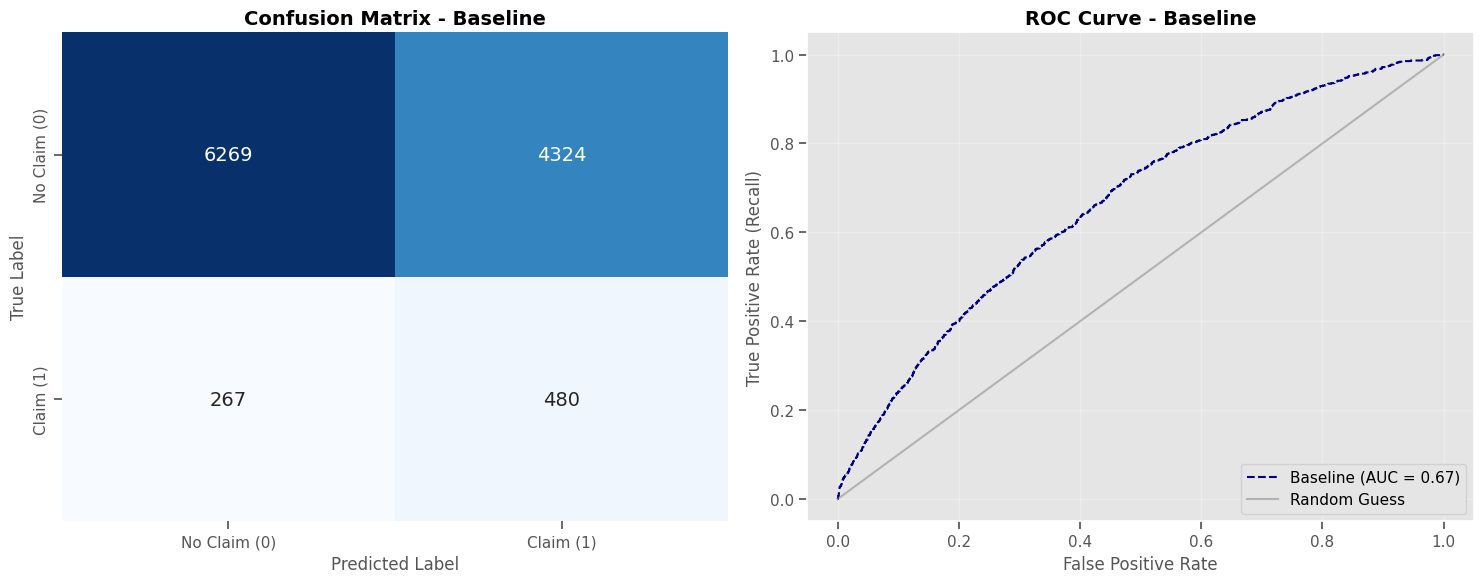

In [44]:
y_probs = model.predict_proba(X)[:, 1]

# 2. CALCULAR AUC-ROC (Discriminación General)
auc_score = roc_auc_score(y, y_probs)
lift = calculate_lift(y, y_probs, percentile=10)
y_pred_class = (y_probs >= 0.5).astype(int)
print(classification_report(y, y_pred_class, zero_division=0))
print(f"AUC: {auc_score:.4f}, Lift@10: {lift:.4f}")

# Prepare Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Calculate confusion matrix
cm = confusion_matrix(y, y_pred_class)
# Heatmap with annotations
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax[0], annot_kws={"size": 14}
)
ax[0].set_title("Confusion Matrix - Baseline", fontsize=14, fontweight="bold")
ax[0].set_xlabel("Predicted Label", fontsize=12)
ax[0].set_ylabel("True Label", fontsize=12)
ax[0].set_xticklabels(["No Claim (0)", "Claim (1)"])
ax[0].set_yticklabels(["No Claim (0)", "Claim (1)"])

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y, y_probs)

# Plot
ax[1].plot(
    fpr, tpr, linestyle="--", color="navy", label=f"Baseline (AUC = {auc_score:.2f})"
)
ax[1].plot([0, 1], [0, 1], color="gray", linestyle="-", alpha=0.5, label="Random Guess")

ax[1].set_title("ROC Curve - Baseline", fontsize=14, fontweight="bold")
ax[1].set_xlabel("False Positive Rate", fontsize=12)
ax[1].set_ylabel("True Positive Rate (Recall)", fontsize=12)
ax[1].legend(loc="lower right")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
def create_decile_table(y_true, y_prob):
    df_res = pd.DataFrame({"target": y_true, "prob": y_prob})

    # Divide in 10 deciles
    df_res["decile"] = pd.qcut(df_res["prob"], 10, labels=False, duplicates="drop")
    df_res["decile"] = 9 - df_res["decile"]

    agg = df_res.groupby("decile").agg({"target": ["count", "sum", "mean"]})

    agg.columns = ["clients", "claims", "claims_rate"]

    # metrics
    agg["pct_clients"] = agg["clients"] / agg["clients"].sum()
    agg["pct_claims_acum"] = agg["claims"].cumsum() / agg["claims"].sum()

    # Lift
    global_rate = df_res["target"].mean()
    agg["lift"] = agg["claims_rate"] / global_rate

    return agg


# Ejecutar análisis
lift_table = create_decile_table(y, y_probs)

print("\n📈 Lift Table efficiency (Deciles)")
display(
    lift_table.style.format(
        {"claims_rate": "{:.2%}", "pct_claims_acum": "{:.2%}", "lift": "{:.2f}x"}
    ).background_gradient(subset=["lift"], cmap="Reds")
)


📈 Lift Table efficiency (Deciles)


,clients,claims,claims_rate,pct_clients,pct_claims_acum,lift
decile,,,,,,
0,1134,169,14.90%,0.100000,22.62%,2.26x
1,1134,119,10.49%,0.100000,38.55%,1.59x
2,1134,90,7.94%,0.100000,50.60%,1.20x
3,1134,79,6.97%,0.100000,61.18%,1.06x
4,1134,87,7.67%,0.100000,72.82%,1.16x
5,1134,55,4.85%,0.100000,80.19%,0.74x
6,1134,44,3.88%,0.100000,86.08%,0.59x
7,1134,48,4.23%,0.100000,92.50%,0.64x
8,1134,32,2.82%,0.100000,96.79%,0.43x



SHAP Analysis


/home/kali/Documents/allianz/Car-Insurance-Claim/venv/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


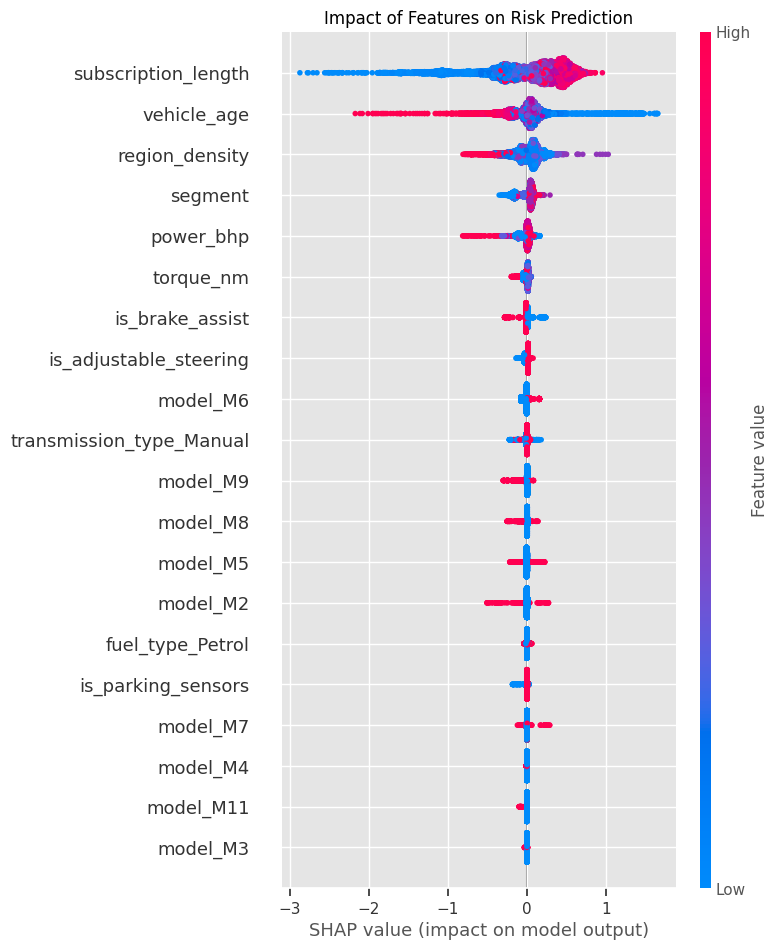

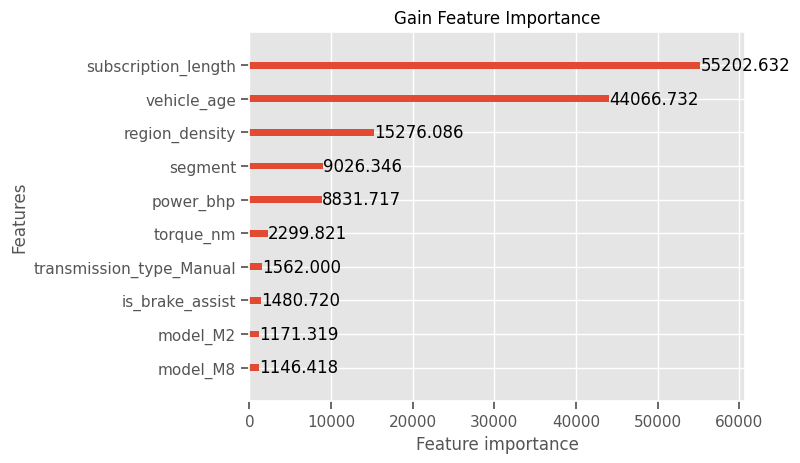

In [47]:
# Solo si lograste instalar SHAP
print("\nSHAP Analysis")

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

vals_to_plot = shap_values[1] if isinstance(shap_values, list) else shap_values

plt.figure(figsize=(10, 8))
shap.summary_plot(vals_to_plot, X, show=False)
plt.title("Impact of Features on Risk Prediction")
plt.show()


lgb.plot_importance(
    model, max_num_features=10, importance_type="gain", title="Gain Feature Importance"
)
plt.show()

## Conclusiones finales

El modelo **LightGBM**, optimizado mediante búsqueda bayesiana, ha sido auditado sobre el conjunto de test para el análisis de reclamos. Los resultados finales de validación son los siguientes:

* **AUC-ROC 0.6661:** Indica una capacidad de discriminación moderada, reflejando la complejidad y el desbalance intrínseco de los datos de seguros.

* **Recall (Clase Reclamos) 0.64:** El modelo logra identificar con éxito el 64% de los siniestros reales, cumpliendo el objetivo operativo de captura de riesgo.

* **Lift @ 10% 2.2490:** En el decil de mayor riesgo, el modelo es 2.25 veces más efectivo que una selección aleatoria para identificar reclamaciones.

## Hallazgos Estratégicos

El análisis de explicabilidad mediante **SHAP Values** revela patrones de comportamiento que desafían las suposiciones convencionales del sector, proporcionando una ventaja estratégica para la toma de decisiones:

1. **El Factor Fidelidad (subscription_length)**
* Hallazgo: A mayor tiempo de permanencia con la póliza, mayor es la probabilidad de realizar un reclamo.

* Interpretación: Los clientes con suscripciones más largas muestran una mayor propensión al reclamo. Esto puede deberse a un mayor conocimiento de las coberturas disponibles, a un uso más intensivo del seguro conforme avanza la relación con la compañía o a un aprovechamiento de la póliza luego de no usarla durante un largo tiempo.

* Acción: Revisar los esquemas de fidelización y ajustar las primas de renovación.

2. **El Factor Novedad del Vehículo (vehicle_age)**
* Hallazgo: A menor edad del vehículo, más probable es que se genere un reclamo.

* Interpretación: Los propietarios de vehículos nuevos tienden a reportar cualquier desperfecto mecánico o estético para hacer valer la garantía o la cobertura total, a diferencia de vehículos antiguos donde el usuario suele omitir reclamos menores.

* Acción: Ajustar los deducibles para vehículos nuevos o implementar inspecciones preventivas más rigurosas durante el primer año.

3. **El Factor Densidad Poblacional (region_density)**
* Hallazgo: El riesgo es mayor en densidades medias. En zonas de densidad muy alta, la probabilidad de reclamo disminuye.

* Interpretación: Las zonas de densidad media suelen permitir velocidades de circulación más altas, lo que incrementa la gravedad de los incidentes. En densidades extremas, el tráfico pesado reduce la velocidad media y, por ende, la frecuencia de colisiones reportables.

* Acción: Refinar el scoring geográfico penalizando áreas de densidad media.

## Próximos Pasos

1. **Mantenimiento del Umbral:** Se recomienda operar con el umbral identificado para mantener el Recall en 0.64, priorizando la detección de siniestros sobre la precisión absoluta.
2. **Enriquecimiento de Datos:** Para superar el límite actual de 0.67 de AUC, es necesario integrar variables externas (historial del conductor o historial del vehiculo), dado que las variables del vehículo han alcanzado su saturación predictiva.
3. **Monitoreo de Deriva (Drift):** Dado que la fidelidad es la variable dominante, se debe monitorear mensualmente si este patrón se mantiene estable en nuevas cohortes de clientes.

## Despliegue y Buenas Prácticas

Este repositorio implementa una estructura sólida para garantizar la calidad y seguridad del código mediante el uso de las siguientes herramientas:

* **Gestión de dependencias:** [Poetry](https://python-poetry.org/)
* **Linters y Formato:** [Ruff](https://docs.astral.sh/ruff/)
* **Seguridad:** [Bandit](https://bandit.readthedocs.io/)
* **Contenedorización:** [Docker](https://www.docker.com/)
* **Hooks de Git:** [Pre-commit](https://pre-commit.com/)

### Automatización (CI/CD)
El proyecto utiliza **GitHub Actions** para la integración y despliegue continuo. Se recomienda seguir este flujo de trabajo:

1.  **Pull Requests:** Activan automáticamente las validaciones de código y seguridad (CI) ya configuradas en el repositorio.
2.  **Despliegue Automático:** Se recomienda configurar GitHub Actions para realizar el despliegue automático tras la aprobación de cambios en la rama principal.